In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# XGBoost
from xgboost import XGBRegressor


# Plot styling
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.2)


In [2]:
df = pd.read_csv("good_coils_10_meter_sampling_combined_added_gauge_target_phase_division.csv")

In [3]:
# df

In [4]:
data = df[df['Phase'] == "Phase 2"][[
    "Coil ID",
    "Stand 1-2 Total Tension Feedback",
    "Stand 2-3 Total Tension Feedback",
    "Stand 3-4 Total Tension Feedback",
    "Stand 1 OS Roll Force",
    "Stand 2 OS Roll Force",
    "Stand 3 OS Roll Force",
    "Stand 4 OS Roll Force",
    "Stand 1 DS Roll Force",
    "Stand 2 DS Roll Force",
    "Stand 3 DS Roll Force",
    "Stand 4 DS Roll Force",
    "Stand 4 DS Total Bending Feedback",
    "Stand 4 DS Bending Shape Trim",
    "Stand 1-3 Solution Temperature",
    "Stand 4 OS Total Bending Feedback",
    "Payoff Reel OS RPM",
    "Payoff Reel DS RPM",
    "Exit Tension Reel RPM",
    "Stand 4 OS Bending Shape Trim",
    "Roll Force Hydraulic Tank Level Inches",
    "Exit Tension Reel Tension Reference",
    "S1 Operating Bending Trim",
    "AGC Alex Dynamic Feedforward Hardness Number",
    "Stand 4 Drive Speed Feedback",
    "Neet Oil Concentration",
    "S3 Operating Bending Trim",
    "Tension Reel Calculated Tension",
    "Stand 3 Top Current Feedback",
    "Stand 3 Drive Speed Feedback",
    "Stand 2 Drive Speed Feedback",
    "X0 Gauge Deviation",
    "X4 Gauge Deviation",
    "X4 Gauge Target",
    "Phase",
    'Driver_Q_VW_OLD_OPTECH','Q2_Q_VW_OLD_OPTECH',
    'Center_Q_VW_OLD_OPTECH','Q1_Q_VW_OLD_OPTECH',
    'Operator_Q_VW_OLD_OPTECH']].copy()
# corr_matrix = data.corr()

# Plot heatmap
# plt.figure(figsize=(36,36))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("Correlation Heatmap", fontsize=16)
# plt.show()


In [5]:
data.dropna(inplace=True)

In [6]:
data['Phase'].value_counts()

Phase
Phase 2    15858
Name: count, dtype: int64

In [7]:
import numpy as np
import pandas as pd

def remove_multicollinearity_and_low_corr(
    X: pd.DataFrame, 
    y: pd.DataFrame, 
    corr_threshold=0.85, 
    target_corr_threshold=0.05
):
    """
    Removes multicollinear features from X and features with low correlation with y.
    Ignores categorical (non-numeric) features before correlation calculation.
    """
    X = X.copy()

    # ---------------------------
    # 0. Keep only numeric columns
    # ---------------------------
    numeric_X = X.select_dtypes(include=[np.number])
    categorical_cols = [col for col in X.columns if col not in numeric_X.columns]
    print(f"Categorical columns ignored (not used for correlation): {categorical_cols}")

    # ---------------------------
    # 1. Remove multicollinear features
    # ---------------------------
    corr_matrix = numeric_X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Drop features with correlation > threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]
    print(f"Columns dropped due to multicollinearity: {to_drop}")
    numeric_X = numeric_X.drop(columns=to_drop)

    # ---------------------------
    # 2. Remove features with low correlation with target(s)
    # ---------------------------
    corr_with_target = pd.DataFrame(index=numeric_X.columns)

    for col in numeric_X.columns:
        correlations = []
        for target in y.columns:
            correlations.append(abs(np.corrcoef(numeric_X[col], y[target])[0, 1]))
        corr_with_target.loc[col, 'max_corr_with_y'] = max(correlations)

    # Features with correlation below threshold
    low_corr_features = corr_with_target[
        corr_with_target['max_corr_with_y'] < target_corr_threshold
    ].index.tolist()

    print(f"Columns dropped due to low correlation with target(s): {low_corr_features}")
    numeric_X = numeric_X.drop(columns=low_corr_features)

    # ---------------------------
    # 3. Final dataset (keep categorical columns as-is)
    # ---------------------------
    final_X = pd.concat([numeric_X, X[categorical_cols]], axis=1)

    return final_X, to_drop, low_corr_features, categorical_cols


In [8]:
X = data[[
    "Coil ID",
    "Stand 1-2 Total Tension Feedback",
    "Stand 2-3 Total Tension Feedback",
    "Stand 3-4 Total Tension Feedback",
    "Stand 1 OS Roll Force",
    "Stand 2 OS Roll Force",
    "Stand 3 OS Roll Force",
    "Stand 4 OS Roll Force",
    "Stand 1 DS Roll Force",
    "Stand 2 DS Roll Force",
    "Stand 3 DS Roll Force",
    "Stand 4 DS Roll Force",
    "Stand 4 DS Total Bending Feedback",
    "Stand 4 DS Bending Shape Trim",
    "Stand 1-3 Solution Temperature",
    "Stand 4 OS Total Bending Feedback",
    "Payoff Reel OS RPM",
    "Payoff Reel DS RPM",
    "Exit Tension Reel RPM",
    "Stand 4 OS Bending Shape Trim",
    "Roll Force Hydraulic Tank Level Inches",
    "Exit Tension Reel Tension Reference",
    "S1 Operating Bending Trim",
    "AGC Alex Dynamic Feedforward Hardness Number",
    "Stand 4 Drive Speed Feedback",
    "Neet Oil Concentration",
    "S3 Operating Bending Trim",
    "Tension Reel Calculated Tension",
    "Stand 3 Top Current Feedback",
    "Stand 3 Drive Speed Feedback",
    "Stand 2 Drive Speed Feedback",
    # "X0 Gauge Deviation",
    # "X4 Gauge Deviation",
    # "Phase",     
    "X4 Gauge Target"
         ]].copy()
y = data[['Driver_Q_VW_OLD_OPTECH','Q2_Q_VW_OLD_OPTECH','Center_Q_VW_OLD_OPTECH','Q1_Q_VW_OLD_OPTECH',
       'Operator_Q_VW_OLD_OPTECH']].copy()

In [9]:
target_columns = ['Driver_Q_VW_OLD_OPTECH','Q2_Q_VW_OLD_OPTECH','Center_Q_VW_OLD_OPTECH','Q1_Q_VW_OLD_OPTECH',
       'Operator_Q_VW_OLD_OPTECH']

In [10]:
X, dropped_multi, dropped_low,categorical_cols = remove_multicollinearity_and_low_corr(X, y,
                               corr_threshold=0.85,
                               target_corr_threshold=0.05)
print("Final selected features:", X.columns.tolist())


Categorical columns ignored (not used for correlation): []
Columns dropped due to multicollinearity: ['Stand 2-3 Total Tension Feedback', 'Stand 2 OS Roll Force', 'Stand 1 DS Roll Force', 'Stand 2 DS Roll Force', 'Stand 3 DS Roll Force', 'Stand 4 DS Roll Force', 'Payoff Reel DS RPM', 'Tension Reel Calculated Tension', 'Stand 3 Drive Speed Feedback', 'Stand 2 Drive Speed Feedback']
Columns dropped due to low correlation with target(s): []
Final selected features: ['Coil ID', 'Stand 1-2 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback', 'Stand 1 OS Roll Force', 'Stand 3 OS Roll Force', 'Stand 4 OS Roll Force', 'Stand 4 DS Total Bending Feedback', 'Stand 4 DS Bending Shape Trim', 'Stand 1-3 Solution Temperature', 'Stand 4 OS Total Bending Feedback', 'Payoff Reel OS RPM', 'Exit Tension Reel RPM', 'Stand 4 OS Bending Shape Trim', 'Roll Force Hydraulic Tank Level Inches', 'Exit Tension Reel Tension Reference', 'S1 Operating Bending Trim', 'AGC Alex Dynamic Feedforward Hardness Numb

In [11]:
len(X["Coil ID"].unique())

23

In [12]:
def coil_id_train_test_split(X, y, coil_id_col="Coil ID", test_size=0.2, random_state=0):
    """
    Splits X and y into train and test sets based on unique coil IDs.
    Keeps all rows of a coil together in either train or test.
    """
    # Unique coil IDs
    unique_coils = X[coil_id_col].unique()

    # Split coil IDs
    train_coils, test_coils = train_test_split(
        unique_coils, test_size=test_size, random_state=random_state
    )

    # Boolean masks
    train_mask = X[coil_id_col].isin(train_coils)
    test_mask = X[coil_id_col].isin(test_coils)

    # Split datasets
    X_train, X_test = X[train_mask].drop(columns=[coil_id_col]), X[test_mask].drop(columns=[coil_id_col])
    y_train, y_test = y[train_mask], y[test_mask]

    return X_train, X_test, y_train, y_test, train_coils, test_coils
X_train, X_test, y_train, y_test, train_coils, test_coils = coil_id_train_test_split(X,y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def scale_and_encode(X_train, X_test, y_train, y_test):
    """
    Scales numerical columns and label-encodes categorical columns.
    """
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()
    y_test = y_test.copy()

    # Separate numeric and categorical columns
    num_cols = X_train.select_dtypes(include=["number"]).columns
    cat_cols = X_train.select_dtypes(exclude=["number"]).columns

    # ----------------------------
    # Scale numeric features
    # ----------------------------
    scaler_X = StandardScaler()
    X_train[num_cols] = scaler_X.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler_X.transform(X_test[num_cols])

    # ----------------------------
    # Label encode categorical features
    # ----------------------------
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])  # assumes no unseen categories
        label_encoders[col] = le

    # ----------------------------
    # Scale target(s)
    # ----------------------------
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    return X_train, X_test, y_train_scaled, y_test_scaled, scaler_X, scaler_y, label_encoders
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, label_encoders = \
    scale_and_encode(X_train, X_test, y_train, y_test)
# # Ensure numpy arrays
X_train_scaled = np.array(X_train_scaled)
X_test_scaled  = np.array(X_test_scaled)
y_train_scaled = np.array(y_train_scaled)
y_test_scaled  = np.array(y_test_scaled)

In [14]:

# ---------------------------
# XGBoost: One model per target
# ---------------------------
xgb_models = []
y_pred_xgb_scaled = np.zeros_like(y_test_scaled)

for i in range(y.shape[1]):  # loop over target columns
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
    model.fit(
        X_train_scaled, y_train_scaled[:, i],  # example: first target
        eval_set=[(X_train_scaled, y_train_scaled[:, i]), (X_test_scaled, y_test_scaled[:, i])],
        eval_metric="rmse",
        verbose=False
    )
    
    xgb_models.append(model)
    y_pred_xgb_scaled[:, i] = model.predict(X_test_scaled)

# ---------------------------
# Inverse transform predictions back to original scale
# ---------------------------
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb_scaled)

# ---------------------------
# Metrics
# ---------------------------
print("\n--- XGBoost Results ---")
print("MSE :", mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("R²  :", r2_score(y_test, y_pred_xgb, multioutput="uniform_average"))
print("R² per target:", r2_score(y_test, y_pred_xgb, multioutput="raw_values"))

C:\Users\Administrator\miniconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



--- XGBoost Results ---
MSE : 1.0222496458603871
RMSE: 1.011063621074553
MAE : 0.815210291527573
R²  : -1.4479860616429394
R² per target: [ 0.41993465 -1.97887368 -3.3254765  -0.7940652  -1.56144957]


In [64]:
# # ---------------------------
# # Scale Data
# # ---------------------------
# # scaler_X = StandardScaler()
# # scaler_y = StandardScaler()

# # X_train_scaled = scaler_X.fit_transform(X_train)
# # X_test_scaled  = scaler_X.transform(X_test)

# # y_train_scaled = scaler_y.fit_transform(y_train)
# # y_test_scaled  = scaler_y.transform(y_test)

# # ---------------------------
# # Build Improved MLP Model
# # ---------------------------
# model = Sequential([
#     Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(32, activation='relu'),
#     Dense(y_train.shape[1], activation='linear')  # regression output
# ])

# # ---------------------------
# # Compile Model
# # ---------------------------
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='mse',
#               metrics=['mae'])

# # ---------------------------
# # Train Model with Early Stopping
# # ---------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train_scaled, y_train_scaled,
#                     validation_data=(X_test_scaled, y_test_scaled),
#                     epochs=50,
#                     batch_size=32,
#                     verbose=1,
#                     callbacks=[early_stop])

# # ---------------------------
# # Evaluate
# # ---------------------------
# y_pred_scaled = model.predict(X_test_scaled)
# y_pred_ann = scaler_y.inverse_transform(y_pred_scaled)

# mse = mean_squared_error(y_test, y_pred_ann)
# mae = mean_absolute_error(y_test, y_pred_ann)
# r2 = r2_score(y_test, y_pred_ann, multioutput="uniform_average")
# r2_per_target = r2_score(y_test, y_pred_ann, multioutput="raw_values")

# print(f"\nTest MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
# print("R² per target column:", r2_per_target)

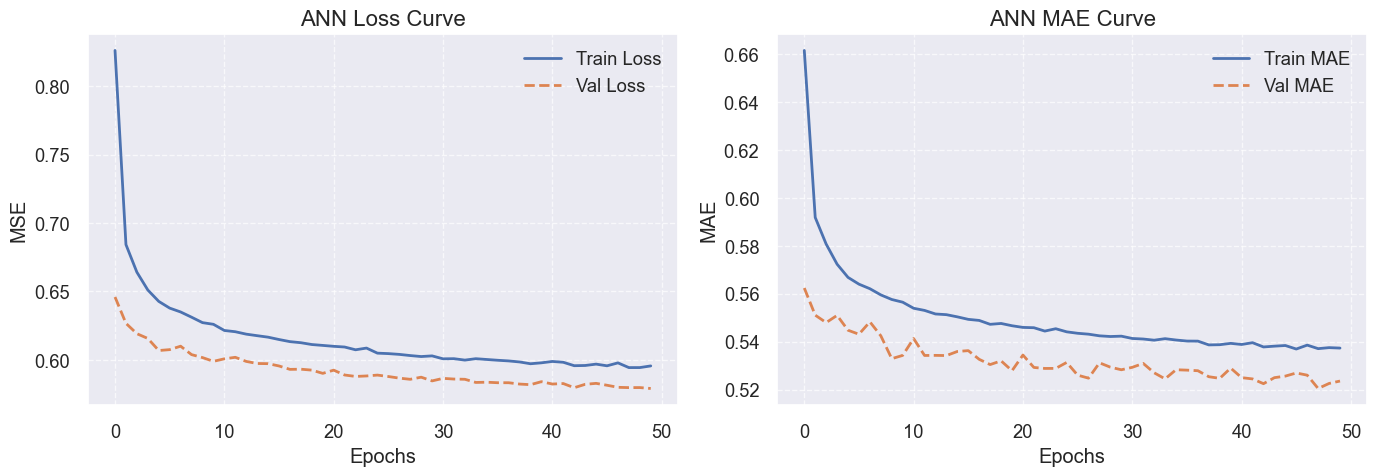

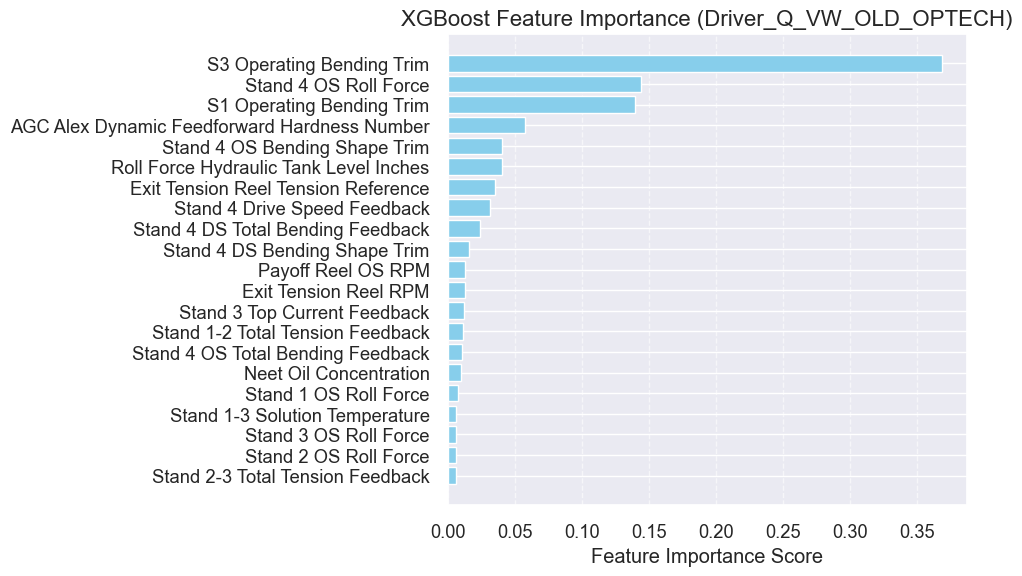

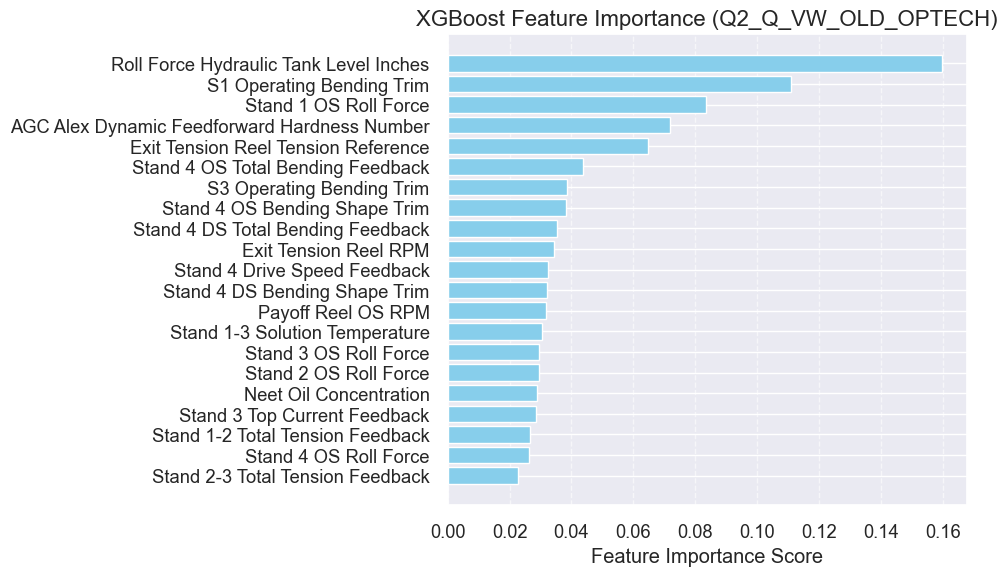

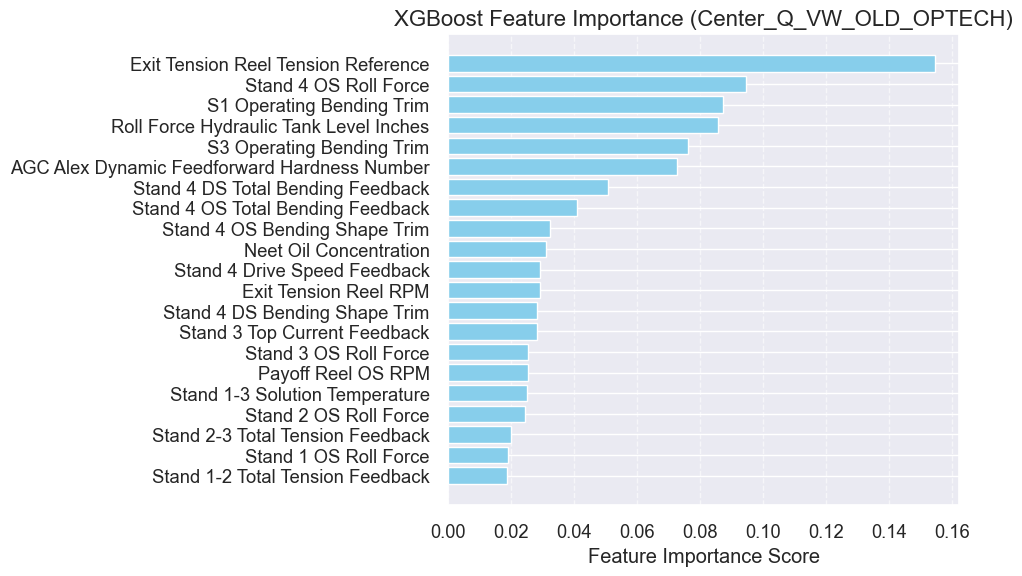

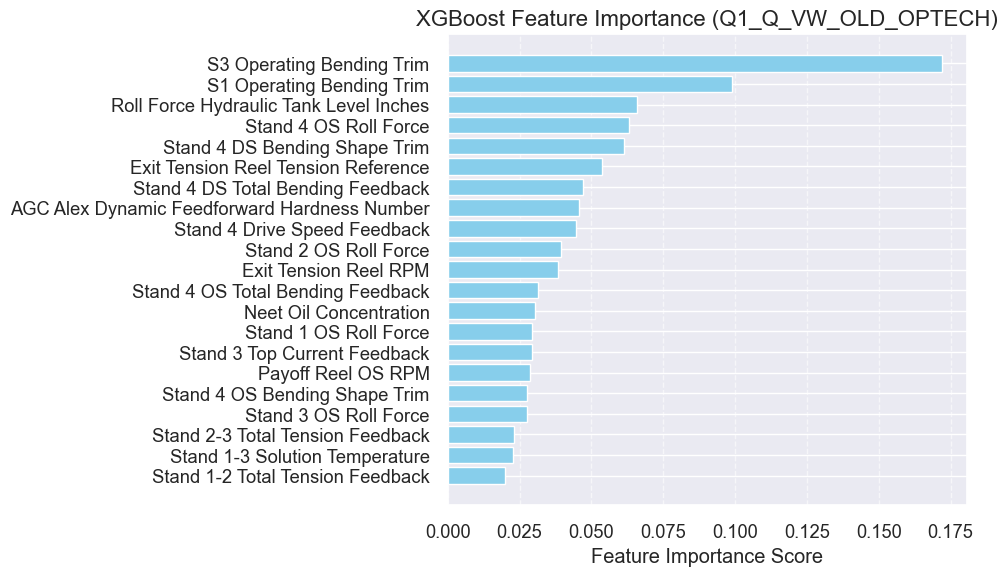

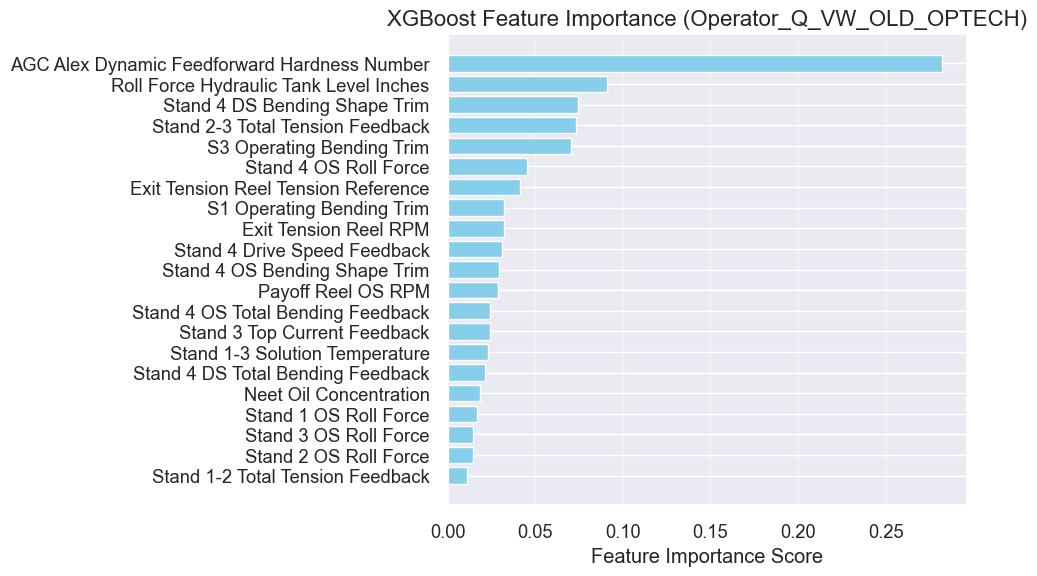

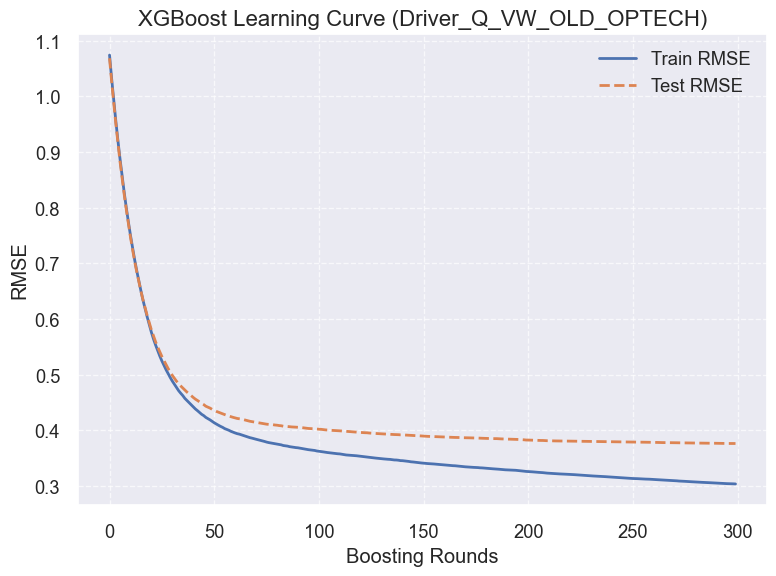

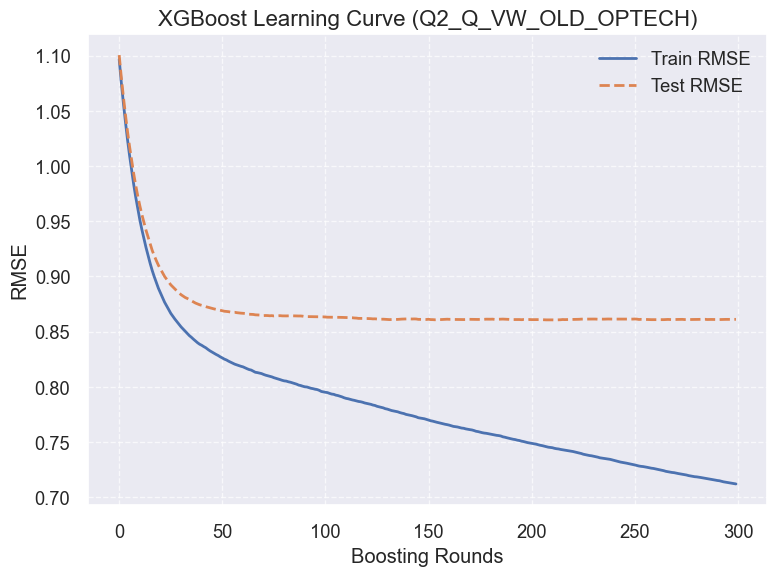

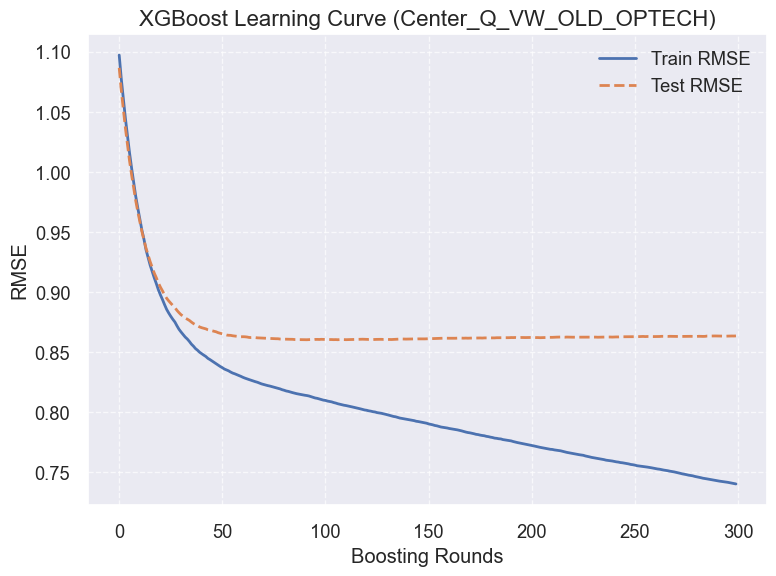

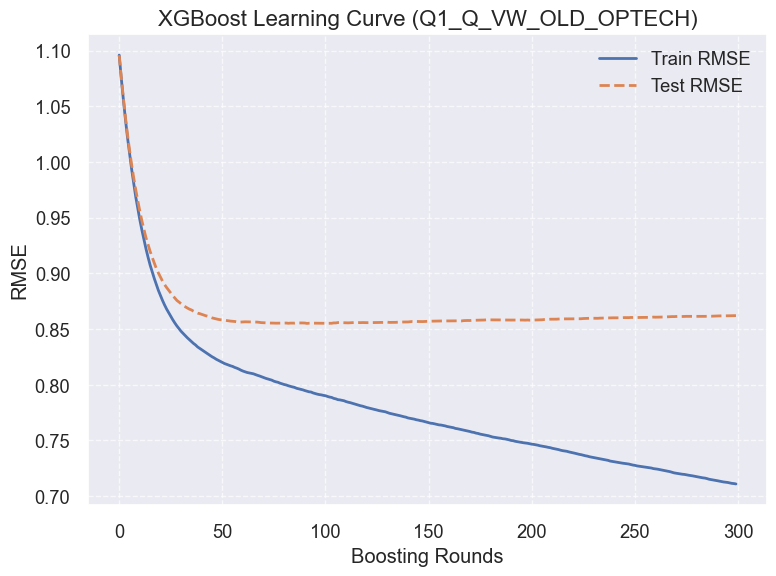

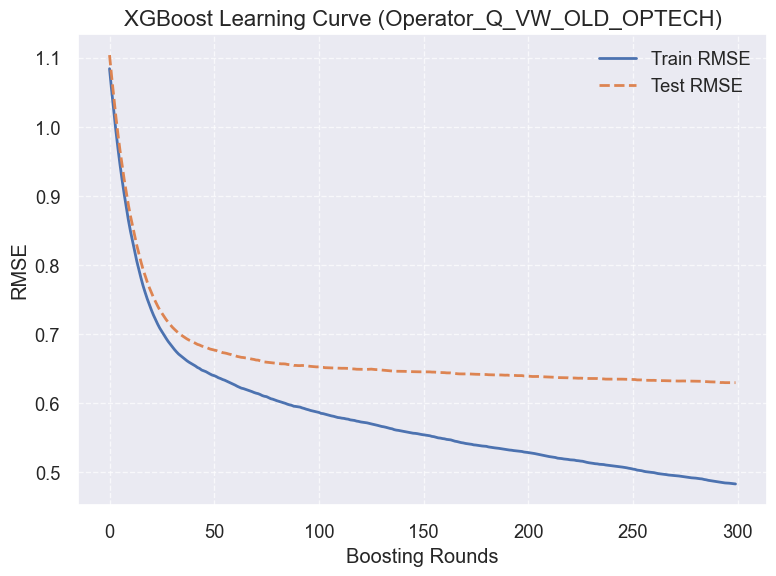

In [57]:
# ---------------------------
# ANN Training Curves
# ---------------------------
def plot_ann_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axs[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axs[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle="--")
    axs[0].set_title("ANN Loss Curve", fontsize=16)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("MSE")
    axs[0].grid(True, linestyle="--", alpha=0.7)
    axs[0].legend()

    # MAE curve
    axs[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axs[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2, linestyle="--")
    axs[1].set_title("ANN MAE Curve", fontsize=16)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("MAE")
    axs[1].grid(True, linestyle="--", alpha=0.7)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Call after ANN training
plot_ann_curves(history)


# ---------------------------
# XGBoost Feature Importance (Horizontal Bars)
# ---------------------------
def plot_xgb_importance(xgb_models, feature_names):
    for i, model in enumerate(xgb_models):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(importance)), importance[sorted_idx], color="skyblue")
        plt.yticks(range(len(importance)), np.array(feature_names)[sorted_idx])
        plt.xlabel("Feature Importance Score")
        plt.title(f"XGBoost Feature Importance ({target_columns[i]})", fontsize=16)
        plt.grid(True, linestyle="--", alpha=0.6, axis="x")
        plt.tight_layout()
        plt.show()

# Call after XGBoost models trained
plot_xgb_importance(xgb_models, X.columns)


# ---------------------------
# XGBoost Learning Curve
# ---------------------------
def plot_xgb_learning_curve(model_curve,i):
    results = model_curve.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE', linewidth=2)
    plt.plot(x_axis, results['validation_1']['rmse'], label='Test RMSE', linewidth=2, linestyle="--")
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title(f'XGBoost Learning Curve ({target_columns[i]})', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example: plot for target 1
for i, model_curve in enumerate(xgb_models):
    plot_xgb_learning_curve(model_curve,i)


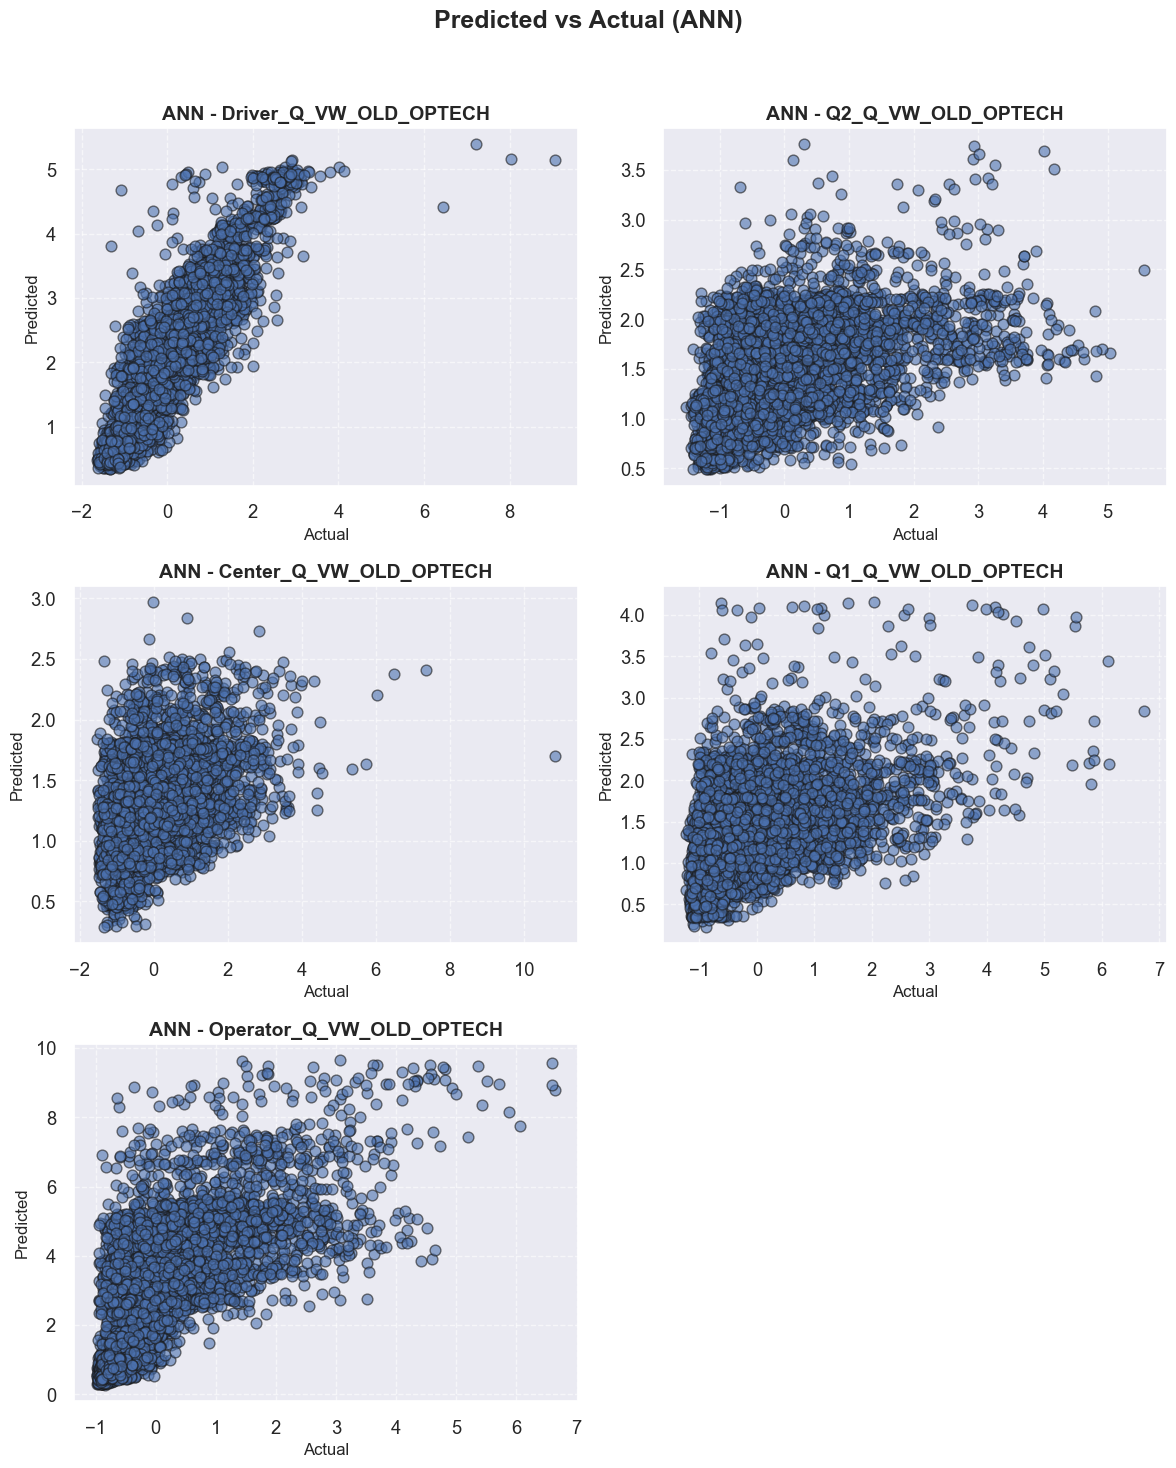

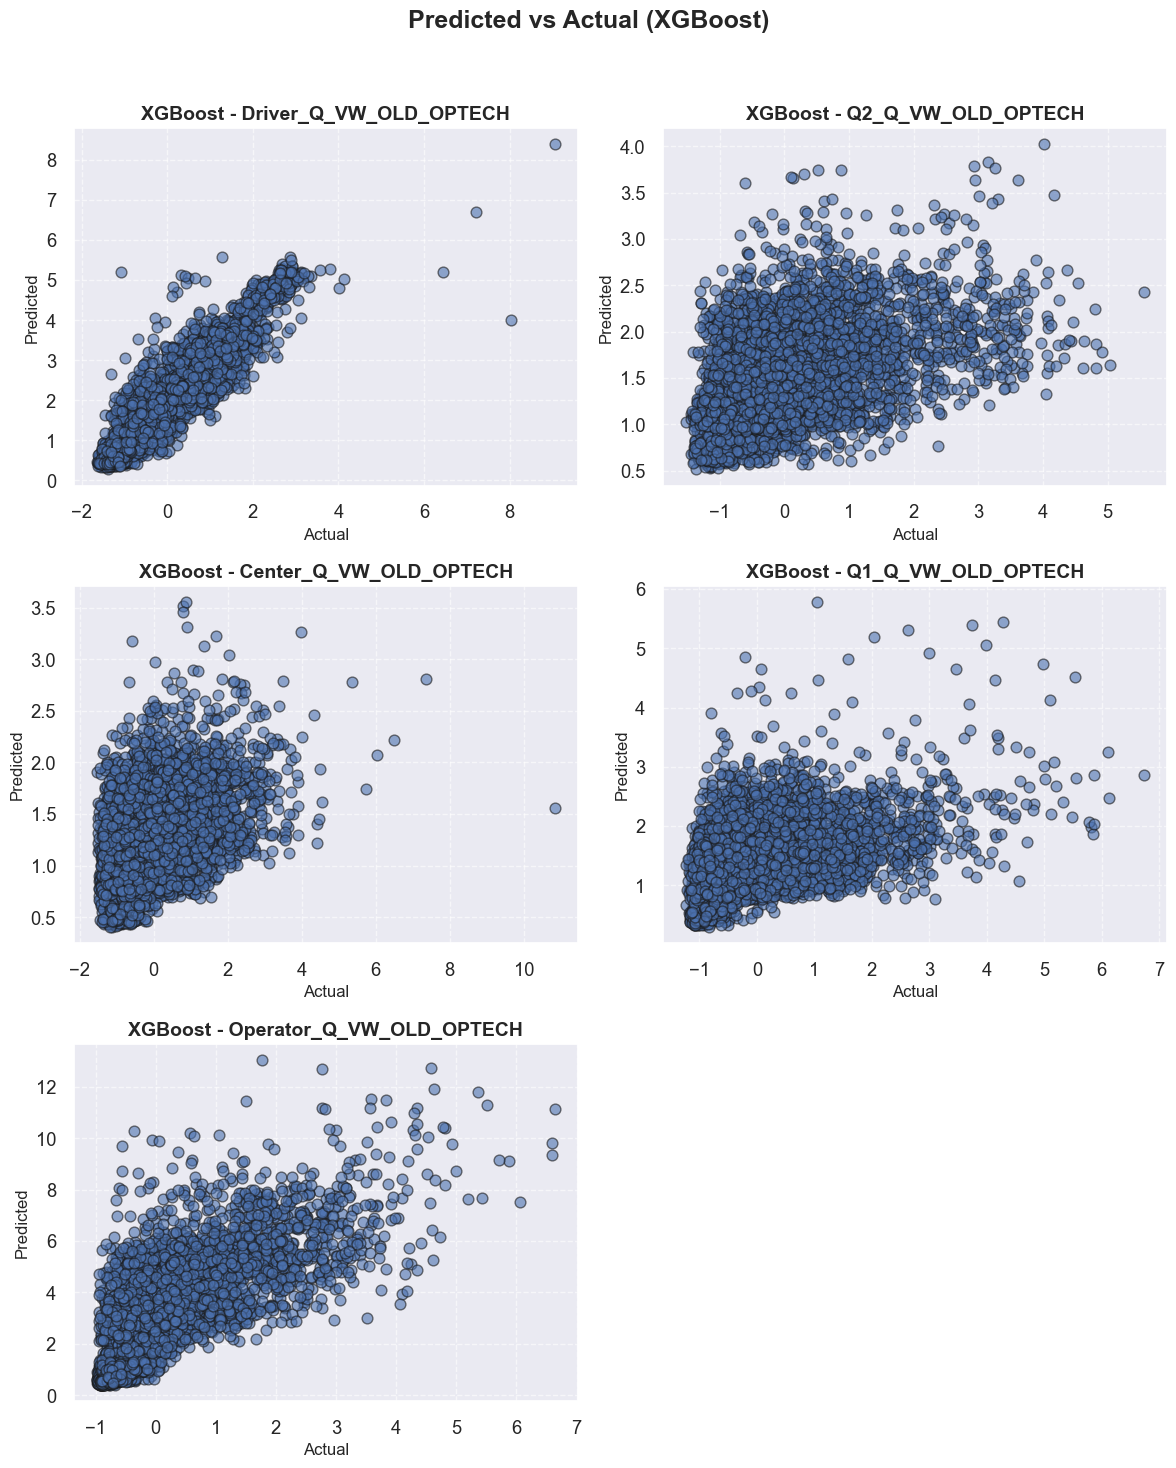

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_predicted_vs_actual(y_true, y_pred, model_name="Model", target_names=None):
    """
    Plot Predicted vs Actual values for regression models.
    
    Parameters:
        y_true (np.ndarray): True target values (n_samples, n_targets)
        y_pred (np.ndarray): Predicted target values (n_samples, n_targets)
        model_name (str): Name of the model (for title)
        target_names (list): List of target variable names (optional)
    """
    n_targets = y_true.shape[1]
    n_cols = 2
    n_rows = math.ceil(n_targets / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_targets):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, edgecolor="k", s=60)

        # Perfect fit line
        # min_val = min(y_true[:, i].min(), y_pred[:, i].min())
        # max_val = max(y_true[:, i].max(), y_pred[:, i].max())
        # ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        # Labels
        target_label = target_names[i] if target_names else f"{target_columns[i]}"
        ax.set_title(f"{model_name} - {target_label}", fontsize=14, fontweight="bold")
        ax.set_xlabel("Actual", fontsize=12)
        ax.set_ylabel("Predicted", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)

    # Remove unused axes if targets < n_rows * n_cols
    for j in range(n_targets, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Predicted vs Actual ({model_name})", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ANN predictions
plot_predicted_vs_actual(y_test_scaled, y_pred_ann, model_name="ANN")

# XGBoost predictions
plot_predicted_vs_actual(y_test_scaled, y_pred_xgb, model_name="XGBoost")


In [59]:
# signal_features = X

## XGB Feature Importance

In [60]:
# # Get the real feature names from signal_features
# real_feature_names = signal_features

# # Create mapping from XGBoost encoded names (f0, f1, f2, ...) to real names
# feature_mapping = {}
# for i, real_name in enumerate(real_feature_names):
#     feature_mapping[f'f{i}'] = real_name

# # Step 1: Raw importance from XGBoost model (using first model as example)
# model = xgb_models[4]  # You can change this to any of your XGB models
# raw_importance = model.get_booster().get_score(importance_type='weight')  # or 'gain', 'cover'

# # Step 2: Convert encoded names to real names
# real_importance = {}
# for encoded_name, importance in raw_importance.items():
#     real_name = feature_mapping.get(encoded_name, encoded_name)  # fallback to encoded if not found
#     real_importance[real_name] = importance

# # Step 3: Create DataFrame with real names
# df_imp = pd.DataFrame.from_dict(real_importance, orient='index', columns=['Importance'])
# df_imp['Importance'] = df_imp['Importance'].astype(float)

# # Step 4: Sort and select top 20
# df_top20 = df_imp.sort_values('Importance', ascending=False).head(20) 
# df_top20['Importance (%)'] = 100 * df_top20['Importance'] / df_top20['Importance'].sum()

# # Round for display
# df_top20['Importance (%)'] = df_top20['Importance (%)'].round(1)

# # Adjust largest value so total is exactly 100%
# total = df_top20['Importance (%)'].sum()
# diff = 100.0 - total
# if abs(diff) > 0 and len(df_top20) > 0:
#     i_max = df_top20['Importance (%)'].idxmax()
#     df_top20.at[i_max, 'Importance (%)'] += diff

# # Step 5: Plot with real feature names
# plt.figure(figsize=(12, 8))
# bars = plt.barh(df_top20.index[::-1], df_top20['Importance (%)'][::-1], color='steelblue')

# # Add percentage labels
# for index, value in enumerate(df_top20['Importance (%)'][::-1]):
#     plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)

# plt.xlabel("Feature Importance (% of Top 20)", fontsize=12)
# plt.ylabel("Signal Features", fontsize=12)
# plt.title("Top 20 XGBoost Feature Importances (Real Signal Names)", fontsize=14)
# plt.tight_layout()
# plt.show()

# # Display the table with real names
# print("Top 20 XGBoost Features with Real Signal Names:")
# print("=" * 60)
# print(df_top20[['Importance (%)']].to_string(float_format='%.1f'))

# print(f"\nTotal: {df_top20['Importance (%)'].sum():.1f}%")
# print(f"Number of features: {len(df_top20)}")

## ANN Feature Importance

In [61]:
# # ANN Feature Importance using Permutation Importance
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

# def permutation_importance_ann(models, X_test, y_test, feature_names, n_repeats=10):
#     """
#     Calculate permutation importance for ANN models
    
#     Parameters:
#     - models: list of trained ANN models (one per target)
#     - X_test: test features
#     - y_test: test targets
#     - feature_names: list of feature names
#     - n_repeats: number of permutation repeats for stability
    
#     Returns:
#     - DataFrame with feature importance scores
#     """
    
#     # Get baseline performance (MSE for all targets combined)
#     y_pred_baseline = np.zeros_like(y_test)
#     for i, model in enumerate(models):
#         y_pred_baseline[:, i] = model.predict(X_test).flatten()
    
#     baseline_mse = mean_squared_error(y_test, y_pred_baseline)
#     print(f"Baseline MSE: {baseline_mse:.4f}")
    
#     # Store importance scores
#     importance_scores = []
    
#     # Loop through each feature
#     for feature_idx in range(X_test.shape[1]):
#         feature_name = feature_names[feature_idx]
        
#         # Store scores for this feature across repeats
#         feature_scores = []
        
#         for repeat in range(n_repeats):
#             # Create copy of test data
#             X_test_permuted = X_test.copy()
            
#             # Permute (shuffle) this feature
#             np.random.seed(repeat * 100 + feature_idx)  # For reproducibility
#             X_test_permuted[:, feature_idx] = np.random.permutation(X_test_permuted[:, feature_idx])
            
#             # Get predictions with permuted feature
#             y_pred_permuted = np.zeros_like(y_test)
#             for i, model in enumerate(models):
#                 y_pred_permuted[:, i] = model.predict(X_test_permuted).flatten()
            
#             # Calculate MSE with permuted feature
#             permuted_mse = mean_squared_error(y_test, y_pred_permuted)
            
#             # Importance = increase in MSE (higher = more important)
#             importance = permuted_mse - baseline_mse
#             feature_scores.append(importance)
        
#         # Average across repeats
#         avg_importance = np.mean(feature_scores)
#         std_importance = np.std(feature_scores)
        
#         importance_scores.append({
#             'feature': feature_name,
#             'importance': avg_importance,
#             'std': std_importance
#         })
        
#         print(f"Feature {feature_idx + 1}/{len(feature_names)}: {feature_name}")
    
#     # Create DataFrame
#     df_importance = pd.DataFrame(importance_scores)
    
#     return df_importance

# # Calculate permutation importance for ANN
# print("Calculating ANN Feature Importance using Permutation Method...")
# print("This may take a few minutes...")

# # Get the real feature names
# real_feature_names = signal_features

# # Calculate importance
# df_ann_importance = permutation_importance_ann(
#     models=ann_models,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=real_feature_names,
#     n_repeats=5  # Reduce if too slow
# )

# # Sort by importance (descending)
# df_ann_importance = df_ann_importance.sort_values('importance', ascending=False)

# # Get top 20 features
# df_ann_top20 = df_ann_importance.head(20).copy()

# # Convert to percentage (relative importance)
# total_importance = df_ann_top20['importance'].sum()
# df_ann_top20['Importance (%)'] = 100 * df_ann_top20['importance'] / total_importance

# # Round for display
# df_ann_top20['Importance (%)'] = df_ann_top20['Importance (%)'].round(1)

# # Adjust largest value so total is exactly 100%
# total_pct = df_ann_top20['Importance (%)'].sum()
# diff = 100.0 - total_pct
# if abs(diff) > 0 and len(df_ann_top20) > 0:
#     i_max = df_ann_top20['Importance (%)'].idxmax()
#     df_ann_top20.at[i_max, 'Importance (%)'] += diff

# # Set feature names as index for plotting
# df_ann_top20_plot = df_ann_top20.set_index('feature')

# # Plot ANN feature importance
# plt.figure(figsize=(12, 8))
# bars = plt.barh(df_ann_top20_plot.index[::-1], df_ann_top20_plot['Importance (%)'][::-1], 
#                 color='darkgreen', alpha=0.7)

# # Add percentage labels
# for index, value in enumerate(df_ann_top20_plot['Importance (%)'][::-1]):
#     plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)

# plt.xlabel("Feature Importance (% of Top 20)", fontsize=12)
# plt.ylabel("Signal Features", fontsize=12)
# plt.title("Top 20 ANN Feature Importances (Permutation Method)", fontsize=14)
# plt.tight_layout()
# plt.show()

# # Display the results
# print("\nTop 20 ANN Features using Permutation Importance:")
# print("=" * 70)
# display_df = df_ann_top20[['feature', 'Importance (%)']].copy()
# display_df.index = range(1, len(display_df) + 1)
# print(display_df.to_string(index=True, float_format='%.1f'))
# print(f"\nTotal: {df_ann_top20['Importance (%)'].sum():.1f}%")
# print(f"Number of features: {len(df_ann_top20)}")

# # Optional: Compare with XGBoost
# print("\n" + "="*80)
# print("COMPARISON: Top 10 Features")
# print("="*80)

# # Get top 10 from each method
# xgb_top10 = df_top20.head(10).index.tolist()
# ann_top10 = df_ann_top20.head(10)['feature'].tolist()

# print("XGBoost Top 10:", xgb_top10[:5], "...")
# print("ANN Top 10:    ", ann_top10[:5], "...")

# # Find common features
# common_features = set(xgb_top10) & set(ann_top10)
# print(f"\nCommon features in top 10: {len(common_features)}")
# if common_features:
#     print("Common features:", list(common_features))